# UK Road Safety: Traffic Accidents and Vehicles - Feature Engineering
## Detailed dataset of road accidents and involved vehicles in the UK (2005-2016)
Source:
<U>https://www.kaggle.com/tsiaras/uk-road-safety-accidents-and-vehicles#Accident_Information.csv</U>
    



# Standard imports
+useful figure save function

In [42]:
# The code was removed by Watson Studio for sharing.

2018-11-08 07:42:41,511 - __PROJECT_LIB__ - ERROR - ProjectAPIProxy__get_project(): unexpected response status: {"code":400,"error":"Bad Request","reason":"Tenant token can only be used in operations involving its associated project resource (i.e. existing tenant) represented by a valid GUID.","message":"The server cannot or will not process the request due to an apparent client error (e.g. malformed request syntax)."}


ValueError: Something went wrong! error message:ProjectAPIProxy__get_project(): unexpected response status: {"code":400,"error":"Bad Request","reason":"Tenant token can only be used in operations involving its associated project resource (i.e. existing tenant) represented by a valid GUID.","message":"The server cannot or will not process the request due to an apparent client error (e.g. malformed request syntax)."}!

In [11]:
import random as rnd
import numpy as np
import pandas as pd
import time
import datetime
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')
cmap=plt.get_cmap('Pastel2')
#cmap=plt.get_cmap('tab20c')

mypath_ = !pwd

def save_fig(fig_id, fig_txt, tight_layout=True, fig_extension="png", resolution=300):
    #generic function to save images to file
    filename =  mypath_[0]+'/img/' + fig_txt + "." + fig_extension
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    fig_id.savefig(filename, format=fig_extension, dpi=resolution, bbox_inches='tight')
    file_data=open(filename, 'rb')
    project.save_data(data=file_data.read(),file_name=fig_txt+'.png',overwrite=True)
    file_data.close() 

    

# Load data from Parquet files
Allow for loading a sample for testing

In [12]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

rdd_accidents = spark.read.load("accidents.parquet")

#Uncomment to select subset of the data
######################## UNCOMMENT FOR TESTING ##########################
#rdd_accidents = rdd_accidents.sample(withReplacement=False, fraction=0.1)
#########################################################################

rdd_accidents.head()

Row(Accident_Index='2011440485653', 1st_Road_Class='Unclassified', 1st_Road_Number='0', 2nd_Road_Class='Unclassified', 2nd_Road_Number='0', Accident_Severity='Slight', Carriageway_Hazards='None', Date='2011-11-16', Day_of_Week='Wednesday', Did_Police_Officer_Attend_Scene_of_Accident='1', Junction_Control='Give way or uncontrolled', Junction_Detail='T or staggered junction', Latitude=50.931155, Light_Conditions='Darkness - no lighting', Local_Authority_District='Eastleigh', Local_Authority_Highway='Hampshire', Location_Easting_OSGR=445560, Location_Northing_OSGR=114840, Longitude=-1.353069, LSOA_of_Accident_Location='E01022716', Number_of_Casualties=1, Number_of_Vehicles=1, Pedestrian_Crossing_Human_Control='0', Pedestrian_Crossing_Physical_Facilities='0', Police_Force='Hampshire', Road_Surface_Conditions='Dry', Road_Type='Single carriageway', Special_Conditions_at_Site='None', Speed_limit=30, Time='16:49', Urban_or_Rural_Area='Urban', Weather_Conditions='Fine no high winds', Year=2011,

# Data Cleansing

## Create SQL view and check datatypes
<b>Some type-casting was already done in the ETL step</b>

In [13]:
#rename columns with special characters
rdd_accidents = rdd_accidents.withColumnRenamed("Local_Authority_(District)", "Local_Authority_District")\
    .withColumnRenamed("Local_Authority_(Highway)", "Local_Authority_Highway")\
    .withColumnRenamed("Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing_Human_Control")\
    .withColumnRenamed("Pedestrian_Crossing-Physical_Facilities", "Pedestrian_Crossing_Physical_Facilities")
#create Hour column
#rdd_accidents = rdd_accidents.withColumn("Hour", rdd_accidents["Time"].substr(0, 2).cast("int"))

rdd_accidents.createOrReplaceTempView("accidents")
rdd_accidents.printSchema()
print("number of records: {:d}".format(rdd_accidents.count()))


root
 |-- Accident_Index: string (nullable = true)
 |-- 1st_Road_Class: string (nullable = true)
 |-- 1st_Road_Number: string (nullable = true)
 |-- 2nd_Road_Class: string (nullable = true)
 |-- 2nd_Road_Number: string (nullable = true)
 |-- Accident_Severity: string (nullable = true)
 |-- Carriageway_Hazards: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day_of_Week: string (nullable = true)
 |-- Did_Police_Officer_Attend_Scene_of_Accident: string (nullable = true)
 |-- Junction_Control: string (nullable = true)
 |-- Junction_Detail: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Light_Conditions: string (nullable = true)
 |-- Local_Authority_District: string (nullable = true)
 |-- Local_Authority_Highway: string (nullable = true)
 |-- Location_Easting_OSGR: integer (nullable = true)
 |-- Location_Northing_OSGR: integer (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- LSOA_of_Accident_Location: string (nullable = true)
 |-- Num

## Check numerical data ranges


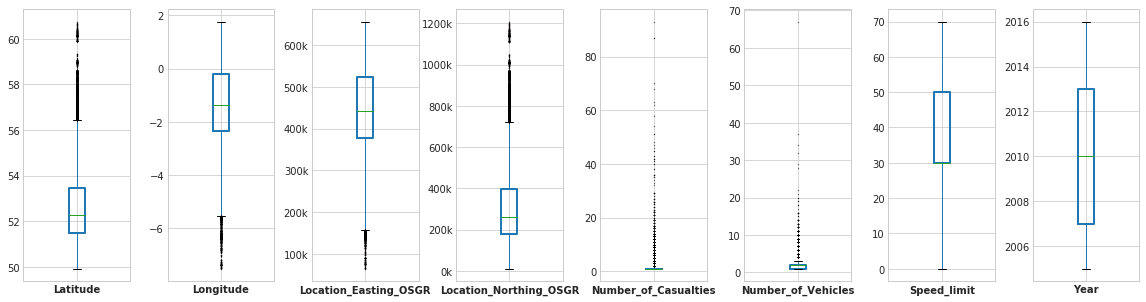

In [4]:
numerical_feat =[
'Latitude',
'Longitude',
'Location_Easting_OSGR',
'Location_Northing_OSGR',
'Number_of_Casualties',
'Number_of_Vehicles',
'Speed_limit',
'Year']
sql_query= '''SELECT {} FROM {}'''
rdd_num_cols = spark.sql(sql_query.format(', '.join(numerical_feat), "accidents")).toPandas()

fig, axes = plt.subplots(nrows=1, ncols=len(numerical_feat), figsize=(20,5))
mkr = dict(markerfacecolor='r', markeredgecolor=None,  marker='.', markersize=0.5)
for i,col in enumerate(numerical_feat):
    rdd_num_cols.boxplot(column=col, ax=axes[i], flierprops=mkr, boxprops= dict(linewidth=2.0))
    axes[i].set_xticklabels(labels=axes[i].get_xticklabels(), fontweight='bold')
axes[2].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}k".format(x/1000)))
axes[3].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}k".format(x/1000)))
plt.subplots_adjust(wspace=0.35)

<b>Boxplots show no unreasonable outliers</b>

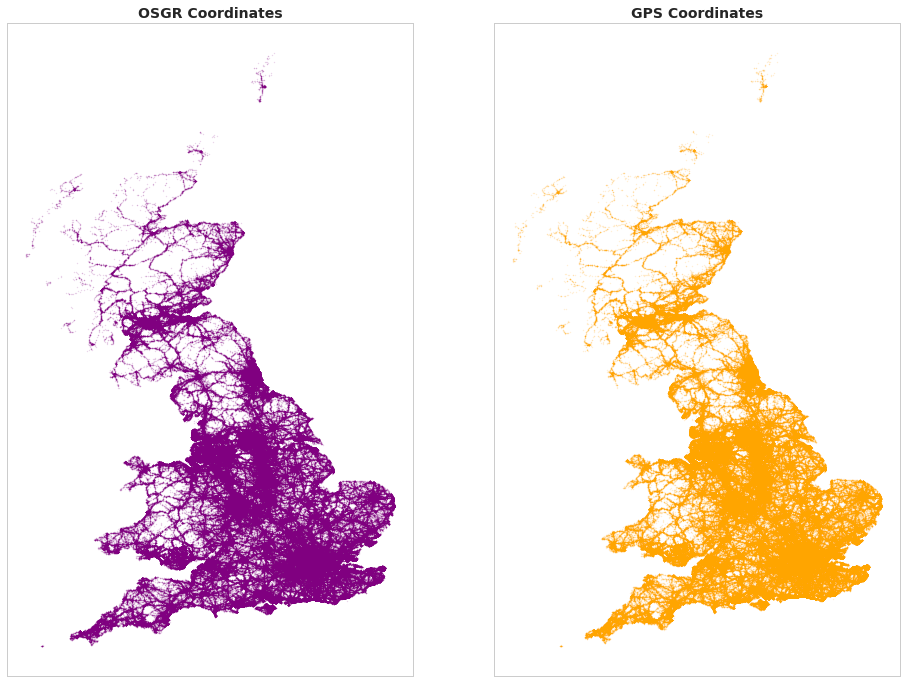

In [5]:
#Check that LSOA data is consistent with GPS Coordinates
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,12))
ax1.scatter(rdd_num_cols.Location_Easting_OSGR,rdd_num_cols.Location_Northing_OSGR, marker='.', alpha=0.2, s=0.5, c='purple')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("OSGR Coordinates", fontweight='bold', fontsize=14)
ax2.scatter(rdd_num_cols.Longitude,rdd_num_cols.Latitude, marker='.', alpha=0.2, s=0.5, c='orange')
ax2.set_xticks([])
ax2.set_yticks([])
t=ax2.set_title("GPS Coordinates", fontweight='bold', fontsize=14)


<b>Coordinates data are consistent</b>

## Check categorical data ranges

Categorical columns split into 5 groups

In [14]:
# Accident_Index, Date and LSOA_of_Accident_Location excluded
cat_cols1=[    
 'Accident_Severity',
 'Day_of_Week',
 'Urban_or_Rural_Area']
cat_cols2=[    
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Light_Conditions',
 'Special_Conditions_at_Site']
cat_cols3=[
 '1st_Road_Class',
 '2nd_Road_Class',
 'Road_Type',
 'Carriageway_Hazards']
cat_cols4=[    
 'Junction_Control',
 'Junction_Detail',
 'Pedestrian_Crossing_Human_Control',
 'Pedestrian_Crossing_Physical_Facilities']
cat_cols5=[    
 'Did_Police_Officer_Attend_Scene_of_Accident',
 'InScotland']



In [7]:
#del rdd_num_cols
cat_cols = cat_cols1+cat_cols2+cat_cols3+cat_cols4+cat_cols5
cat_labels={}
for col in cat_cols:
    sql_query= '''SELECT {}, COUNT({})* 100.0 / (select count(*) from {}) AS Pct FROM {} GROUP BY {}'''
    rdd_cat= spark.sql(sql_query.format(col, col,"accidents", "accidents",col)).toPandas()
    rdd_cat['Pct'] = rdd_cat['Pct'].map('{:,.1f}'.format)
    cat_labels[col] = list(rdd_cat[col].values)
    display(rdd_cat)


,Accident_Severity,Pct
0,Slight,85.0
1,Fatal,1.3
2,Serious,13.8


,Day_of_Week,Pct
0,Wednesday,15.1
1,Tuesday,15.0
2,Friday,16.4
3,Thursday,15.0
4,Saturday,13.3
5,Monday,14.2
6,Sunday,11.0


,Urban_or_Rural_Area,Pct
0,Unallocated,0.0
1,Urban,64.4
2,Rural,35.6


,Weather_Conditions,Pct
0,Raining + high winds,1.4
1,Snowing no high winds,0.7
2,Unknown,2.0
3,Other,2.2
4,Fine no high winds,80.1
5,Snowing + high winds,0.1
6,Raining no high winds,11.7
7,Data missing or out of range,0.0
8,Fog or mist,0.5
9,Fine + high winds,1.3


,Road_Surface_Conditions,Pct
0,Wet or damp,28.0
1,Dry,69.1
2,Flood over 3cm. deep,0.1
3,Frost or ice,2.0
4,Snow,0.6
5,Data missing or out of range,0.2


,Light_Conditions,Pct
0,Darkness - lights unlit,0.5
1,Darkness - lighting unknown,1.1
2,Daylight,73.2
3,Darkness - lights lit,19.7
4,Data missing or out of range,0.0
5,Darkness - no lighting,5.5


,Special_Conditions_at_Site,Pct
0,Mud,0.3
1,None,97.5
2,Roadworks,1.2
3,Oil or diesel,0.3
4,Auto signal part defective,0.0
5,Road surface defective,0.2
6,Auto traffic signal - out,0.2
7,Data missing or out of range,0.0
8,Road sign or marking defective or obscured,0.1


,1st_Road_Class,Pct
0,A(M),0.3
1,Motorway,3.8
2,B,12.7
3,C,8.7
4,A,45.4
5,Unclassified,29.1


,2nd_Road_Class,Pct
0,A(M),0.1
1,Motorway,0.7
2,NA,41.2
3,B,3.9
4,C,4.6
5,A,9.8
6,Unclassified,39.8


,Road_Type,Pct
0,Slip road,1.0
1,One way street,2.1
2,Unknown,0.6
3,Roundabout,6.7
4,Single carriageway,74.8
5,Dual carriageway,14.8
6,Data missing or out of range,0.0


,Carriageway_Hazards,Pct
0,None,98.2
1,Previous accident,0.2
2,Other object on road,0.8
3,Vehicle load on road,0.1
4,Pedestrian in carriageway - not injured,0.2
5,Any animal in carriageway (except ridden horse),0.5
6,Data missing or out of range,0.0


,Junction_Control,Pct
0,Stop sign,0.6
1,Give way or uncontrolled,48.5
2,Authorised person,0.2
3,Data missing or out of range,36.4
4,Auto traffic signal,10.3
5,Not at junction or within 20 metres,4.0


,Junction_Detail,Pct
0,Other junction,2.9
1,Mini-roundabout,1.1
2,T or staggered junction,31.1
3,Slip road,1.5
4,Roundabout,8.7
5,More than 4 arms (not roundabout),1.3
6,Private drive or entrance,3.6
7,Data missing or out of range,0.0
8,Crossroads,9.6
9,Not at junction or within 20 metres,40.3


,Pedestrian_Crossing_Human_Control,Pct
0,0,99.4
1,NA,0.0
2,1,0.2
3,2,0.4


,Pedestrian_Crossing_Physical_Facilities,Pct
0,7,0.3
1,8,1.9
2,0,83.1
3,NA,0.0
4,5,6.7
5,1,2.7
6,4,5.3


,Did_Police_Officer_Attend_Scene_of_Accident,Pct
0,3,0.3
1,NA,0.0
2,1,80.5
3,2,19.2


,InScotland,Pct
0,NA,0.0
1,No,93.4
2,Yes,6.6


<b>Some categorical variables have missing data ('Unallocated', 'Data missing or out of range' or 'NA')</b><br>
<b>We simply remove the missing data when it represents less than 1% of total number of records</b><br>
<b>The 41% of NA values for '2nd_Road_Class' corresponds to the 40% of accidents not occuring at a Junction (so on a single road)</b>


In [8]:
def unselect_row(cols, cond, df_view):
    for col in cols:
        sql_query = '''SELECT * FROM {} WHERE {} != {}'''
        rdd_new = spark.sql(sql_query.format(df_view, col, "'"+cond+"'"))
        rdd_new.createOrReplaceTempView(df_view)
    return rdd_new


#Delete 'Unallocated' from 
cols=['Urban_or_Rural_Area']
rdd_accidents = unselect_row(cols, 'Unallocated', "accidents")

#Delete all 'Data missing or out of range' from:
cols=['Weather_Conditions',
'Road_Surface_Conditions',
'Light_Conditions',
'Special_Conditions_at_Site',
'Road_Type',
'Carriageway_Hazards',
'Junction_Detail']
rdd_accidents = unselect_row(cols, 'Data missing or out of range', "accidents")

#delete all 'NA' from:
cols = ['Pedestrian_Crossing_Human_Control',
'Pedestrian_Crossing_Physical_Facilities',
'Did_Police_Officer_Attend_Scene_of_Accident',
'InScotland']
rdd_accidents = unselect_row(cols, 'NA', "accidents")

cat_cols = cat_cols1+cat_cols2+cat_cols3+cat_cols4+cat_cols5
cat_labels={}
for col in cat_cols:
    sql_query= '''SELECT {}, COUNT({})* 100.0 / (SELECT COUNT(*) FROM {}) AS Pct FROM {} GROUP BY {}'''
    rdd_cat= spark.sql(sql_query.format(col, col,"accidents", "accidents",col)).toPandas()
    rdd_cat['Pct'] = rdd_cat['Pct'].map('{:,.1f}'.format)
    cat_labels[col] = list(rdd_cat[col].values)
    display(rdd_cat)


,Accident_Severity,Pct
0,Slight,84.9
1,Fatal,1.3
2,Serious,13.8


,Day_of_Week,Pct
0,Wednesday,15.1
1,Tuesday,15.0
2,Friday,16.4
3,Thursday,15.0
4,Saturday,13.3
5,Monday,14.2
6,Sunday,11.0


,Urban_or_Rural_Area,Pct
0,Urban,64.4
1,Rural,35.6


,Weather_Conditions,Pct
0,Raining + high winds,1.4
1,Snowing no high winds,0.7
2,Unknown,1.9
3,Other,2.2
4,Fine no high winds,80.2
5,Snowing + high winds,0.1
6,Raining no high winds,11.8
7,Fog or mist,0.5
8,Fine + high winds,1.3


,Road_Surface_Conditions,Pct
0,Wet or damp,28.0
1,Dry,69.3
2,Flood over 3cm. deep,0.1
3,Frost or ice,2.0
4,Snow,0.6


,Light_Conditions,Pct
0,Darkness - lights unlit,0.5
1,Darkness - lighting unknown,1.1
2,Daylight,73.2
3,Darkness - lights lit,19.7
4,Darkness - no lighting,5.5


,Special_Conditions_at_Site,Pct
0,Mud,0.3
1,None,97.6
2,Roadworks,1.2
3,Oil or diesel,0.3
4,Auto signal part defective,0.0
5,Road surface defective,0.2
6,Auto traffic signal - out,0.2
7,Road sign or marking defective or obscured,0.1


,1st_Road_Class,Pct
0,A(M),0.3
1,Motorway,3.8
2,B,12.7
3,C,8.7
4,A,45.4
5,Unclassified,29.1


,2nd_Road_Class,Pct
0,A(M),0.1
1,Motorway,0.7
2,NA,41.2
3,B,3.9
4,C,4.6
5,A,9.8
6,Unclassified,39.8


,Road_Type,Pct
0,Slip road,1.0
1,One way street,2.1
2,Unknown,0.6
3,Roundabout,6.7
4,Single carriageway,74.8
5,Dual carriageway,14.8


,Carriageway_Hazards,Pct
0,None,98.2
1,Previous accident,0.2
2,Other object on road,0.8
3,Vehicle load on road,0.1
4,Pedestrian in carriageway - not injured,0.2
5,Any animal in carriageway (except ridden horse),0.5


,Junction_Control,Pct
0,Stop sign,0.6
1,Give way or uncontrolled,48.5
2,Authorised person,0.2
3,Data missing or out of range,36.4
4,Auto traffic signal,10.3
5,Not at junction or within 20 metres,4.0


,Junction_Detail,Pct
0,Other junction,2.9
1,Mini-roundabout,1.1
2,T or staggered junction,31.1
3,Slip road,1.5
4,Roundabout,8.7
5,More than 4 arms (not roundabout),1.3
6,Private drive or entrance,3.6
7,Crossroads,9.6
8,Not at junction or within 20 metres,40.3


,Pedestrian_Crossing_Human_Control,Pct
0,0,99.4
1,1,0.2
2,2,0.4


,Pedestrian_Crossing_Physical_Facilities,Pct
0,7,0.3
1,8,1.9
2,0,83.2
3,5,6.7
4,1,2.7
5,4,5.3


,Did_Police_Officer_Attend_Scene_of_Accident,Pct
0,3,0.2
1,1,80.6
2,2,19.2


,InScotland,Pct
0,No,93.4
1,Yes,6.6


# Feature Engineering


## Create a Week Feature from Date
<b>This would allow a model to incorporate seasonal effects (holidays, weather etc..)</b>

In [7]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *


def date_to_week(date_str):
    return datetime.datetime.strptime(date_str,'%Y-%m-%d').date().isocalendar()[1]

udf_date_to_week = udf(date_to_week, IntegerType())
rdd_accidents = rdd_accidents.withColumn("Week", udf_date_to_week("Date"))

rdd_accidents.head()

Row(Accident_Index='2011440485653', 1st_Road_Class='Unclassified', 1st_Road_Number='0', 2nd_Road_Class='Unclassified', 2nd_Road_Number='0', Accident_Severity='Slight', Carriageway_Hazards='None', Date='2011-11-16', Day_of_Week='Wednesday', Did_Police_Officer_Attend_Scene_of_Accident='1', Junction_Control='Give way or uncontrolled', Junction_Detail='T or staggered junction', Latitude=50.931155, Light_Conditions='Darkness - no lighting', Local_Authority_District='Eastleigh', Local_Authority_Highway='Hampshire', Location_Easting_OSGR=445560, Location_Northing_OSGR=114840, Longitude=-1.353069, LSOA_of_Accident_Location='E01022716', Number_of_Casualties=1, Number_of_Vehicles=1, Pedestrian_Crossing_Human_Control='0', Pedestrian_Crossing_Physical_Facilities='0', Police_Force='Hampshire', Road_Surface_Conditions='Dry', Road_Type='Single carriageway', Special_Conditions_at_Site='None', Speed_limit=30, Time='16:49', Urban_or_Rural_Area='Urban', Weather_Conditions='Fine no high winds', Year=2011,

DataFrame[Week: int, slight: bigint, severe: bigint]

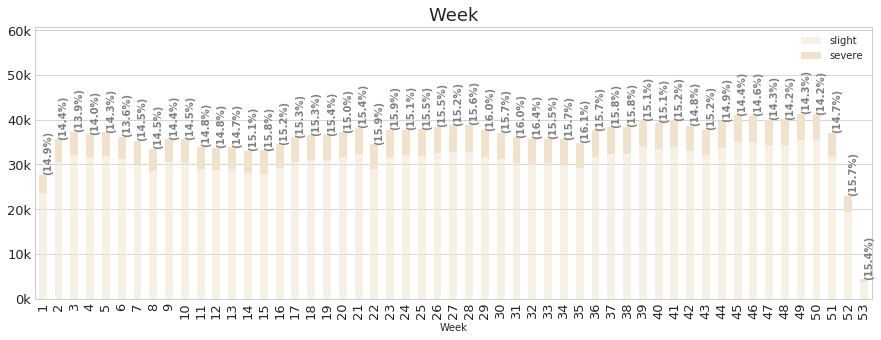

In [10]:
def plot_ord_feature(df_view, col, ax=None, bar_color=cmap(6)):
    severe_col = "Accident_Severity"
    acc_type = "Slight"
    sql_query = '''
    SELECT 
        {},
        COUNT(CASE WHEN {}  = '{}' THEN {} END) AS slight, 
        COUNT(CASE WHEN {} != '{}' THEN {} END) AS severe 
    FROM {} GROUP BY {}'''
    rdd_col = spark.sql(sql_query.format(col, severe_col, acc_type, col,severe_col, acc_type, col, df_view, col))
    df_plot = rdd_col.toPandas().dropna().sort_values(by=[col])
    clrmap = [(bar_color[0],bar_color[1],bar_color[2],bar_color[3]*0.5), bar_color]
    ax = df_plot.plot(col, kind='bar', ax=ax, fontsize=13, title=col.replace('_', ' '), 
                      color=clrmap, stacked=True)
    #ax = plt.gca()
    ax.set_ylabel('')
    ax.set_alpha(0.8)
    ax.xaxis.grid(False)
    ax.set_xticklabels(df_plot[col])
    ax.title.set_size(18)
    for idx, label in enumerate(list(df_plot.index)): 
        total = df_plot.loc[label]['slight']+df_plot.loc[label]['severe']
        value = "({}%)".format(np.round(100*df_plot.loc[label]['severe']/(total),decimals=1))
        ax.annotate(value, (idx, total), xytext=(0, 0), textcoords='offset points',
                   fontsize=10, color='grey', fontweight='bold', rotation=90, va ='bottom')

    #ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:0}".format(x)))
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}k".format(int(x/1000))))
    left, right = ax.get_ylim()  # return the current xlim
    ax.set_ylim((left, right*1.4))    
    return rdd_col

rdd_accidents.createOrReplaceTempView("accidents")
fig, ax = plt.subplots(figsize=(15,5))
plot_ord_feature("accidents", "Week", ax=ax)

## Change 'Fatal' into 'Serious' 
<b>We are looking at a binary classification (predict accident severity Slight vs Serious)</b>

In [11]:
def aggregate_features(feature, from_value_list, to_value, rdd_df, df_view):

    def change_feature(from_value_str):
        return to_value if from_value_str in from_value_list else from_value_str
    
    udf_change = udf(change_feature, StringType())
    rdd_new = rdd_df.withColumn(feature, udf_change(feature))        
    rdd_new.createOrReplaceTempView(df_view)
    return rdd_new


#def fatal_to_serious(severity_str):
#    return 'Serious' if severity_str=='Fatal' else severity_str

#udf_fatal_to_serious = udf(fatal_to_serious, StringType())
#rdd_accidents = rdd_accidents.withColumn("Accident_Severity", udf_fatal_to_serious("Accident_Severity"))

rdd_accidents = aggregate_features("Accident_Severity", ['Fatal'], 'Serious', rdd_accidents, "accidents")

rdd_accidents.head()
#rdd_accidents.createOrReplaceTempView("accidents")


Row(Accident_Index='2011440485653', 1st_Road_Class='Unclassified', 1st_Road_Number='0', 2nd_Road_Class='Unclassified', 2nd_Road_Number='0', Accident_Severity='Slight', Carriageway_Hazards='None', Date='2011-11-16', Day_of_Week='Wednesday', Did_Police_Officer_Attend_Scene_of_Accident='1', Junction_Control='Give way or uncontrolled', Junction_Detail='T or staggered junction', Latitude=50.931155, Light_Conditions='Darkness - no lighting', Local_Authority_District='Eastleigh', Local_Authority_Highway='Hampshire', Location_Easting_OSGR=445560, Location_Northing_OSGR=114840, Longitude=-1.353069, LSOA_of_Accident_Location='E01022716', Number_of_Casualties=1, Number_of_Vehicles=1, Pedestrian_Crossing_Human_Control='0', Pedestrian_Crossing_Physical_Facilities='0', Police_Force='Hampshire', Road_Surface_Conditions='Dry', Road_Type='Single carriageway', Special_Conditions_at_Site='None', Speed_limit=30, Time='16:49', Urban_or_Rural_Area='Urban', Weather_Conditions='Fine no high winds', Year=2011,

## Simplify weather conditions
<b>Merge Unknown and Other</b>

In [12]:
## Simplify weather conditions
#<b>Weather_Conditions	Pct
feature = 'Weather_Conditions'
from_value_list=  ['Unknown', 'Other']
to_value = 'Other'
rdd_accidents = aggregate_features(feature, from_value_list, to_value, rdd_accidents, "accidents")

rdd_accidents.head()

Row(Accident_Index='2011440485653', 1st_Road_Class='Unclassified', 1st_Road_Number='0', 2nd_Road_Class='Unclassified', 2nd_Road_Number='0', Accident_Severity='Slight', Carriageway_Hazards='None', Date='2011-11-16', Day_of_Week='Wednesday', Did_Police_Officer_Attend_Scene_of_Accident='1', Junction_Control='Give way or uncontrolled', Junction_Detail='T or staggered junction', Latitude=50.931155, Light_Conditions='Darkness - no lighting', Local_Authority_District='Eastleigh', Local_Authority_Highway='Hampshire', Location_Easting_OSGR=445560, Location_Northing_OSGR=114840, Longitude=-1.353069, LSOA_of_Accident_Location='E01022716', Number_of_Casualties=1, Number_of_Vehicles=1, Pedestrian_Crossing_Human_Control='0', Pedestrian_Crossing_Physical_Facilities='0', Police_Force='Hampshire', Road_Surface_Conditions='Dry', Road_Type='Single carriageway', Special_Conditions_at_Site='None', Speed_limit=30, Time='16:49', Urban_or_Rural_Area='Urban', Weather_Conditions='Fine no high winds', Year=2011,

## Create a Peak_or_OffPeak Feature from Hour
<b>This would reduce granularity of data and potentially increase model generalisability</b>

In [17]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

def hour_to_peak(hour):
    try:
        return 'Peak' if (hour>=8 and hour<=18) else 'OffPeak'
    except:
        return ''

udf_hour_to_peak = udf(hour_to_peak, StringType())
rdd_accidents = rdd_accidents.withColumn("Peak_or_OffPeak", udf_hour_to_peak("Hour"))

rdd_accidents.head()

Row(Accident_Index='2011440485653', 1st_Road_Class='Unclassified', 1st_Road_Number='0', 2nd_Road_Class='Unclassified', 2nd_Road_Number='0', Accident_Severity='Slight', Carriageway_Hazards='None', Date='2011-11-16', Day_of_Week='Wednesday', Did_Police_Officer_Attend_Scene_of_Accident='1', Junction_Control='Give way or uncontrolled', Junction_Detail='T or staggered junction', Latitude=50.931155, Light_Conditions='Darkness - no lighting', Local_Authority_District='Eastleigh', Local_Authority_Highway='Hampshire', Location_Easting_OSGR=445560, Location_Northing_OSGR=114840, Longitude=-1.353069, LSOA_of_Accident_Location='E01022716', Number_of_Casualties=1, Number_of_Vehicles=1, Pedestrian_Crossing_Human_Control='0', Pedestrian_Crossing_Physical_Facilities='0', Police_Force='Hampshire', Road_Surface_Conditions='Dry', Road_Type='Single carriageway', Special_Conditions_at_Site='None', Speed_limit=30, Time='16:49', Urban_or_Rural_Area='Urban', Weather_Conditions='Fine no high winds', Year=2011,

DataFrame[Peak_or_OffPeak: string, slight: bigint, severe: bigint]

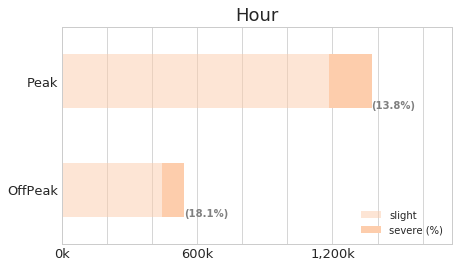

In [45]:
def to_null(c):
        #function to discard NUL NA and empty records
        from pyspark.sql.functions import col, isnan, when, trim
        return when(~(col(c).isNull() | isnan(col(c)) | (trim(col(c)) == "")), col(c))
    

    
def plot_cat_feature(df_view, column, ax=None, bar_color=cmap(1)):
    severe_col = "Accident_Severity"
    acc_type = "Slight"
    sql_query = '''
    SELECT 
        {},
        COUNT(CASE WHEN {}  = '{}' THEN {} END) AS slight, 
        COUNT(CASE WHEN {} != '{}' THEN {} END) AS severe 
    FROM {} GROUP BY {}'''
    rdd_col = spark.sql(sql_query.format(column, severe_col, acc_type, column, severe_col, acc_type, column, df_view, column))
    rdd_col = rdd_col.select([to_null(c).alias(c) for c in rdd_col.columns]).na.drop()
    df_plot = rdd_col.toPandas().dropna().sort_values(by=[column])
    clrmap = [(bar_color[0],bar_color[1],bar_color[2],bar_color[3]*0.5), bar_color]
    ax = df_plot.plot(column, kind='barh', ax=ax, fontsize=13, title=col.replace('_', ' '), 
                   color=clrmap, stacked=True, legend =(False if column==severe_col else True))
    ax.yaxis.grid(False)
    ax.set_ylabel('')
    ax.set_alpha(0.8)
    ax.title.set_size(18)
    for idx, label in enumerate(list(df_plot.index)): 
        total = df_plot.loc[label]['slight']+df_plot.loc[label]['severe']
        value = "({}%)".format(np.round(100*df_plot.loc[label]['severe']/(total),decimals=1))
        ax.annotate(value, (total, idx-ax.patches[0].get_height()/2), xytext=(0, 0), textcoords='offset points',
                   fontsize=10, color='grey', fontweight='bold')
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}k".format(int(x/1000))))
    ax.legend(labels=['slight', 'severe (%)'])
    left, right = ax.get_xlim()  # return the current xlim
    ax.set_xlim((left, right*1.2))   
    xticks = ax.xaxis.get_ticklabels()
    every_nth = round(len(xticks)/3)
    for n, label in enumerate(xticks):
        if n % every_nth != 0:
            label.set_visible(False)
    return rdd_col


fig, ax= plt.subplots(figsize=(7,4))
plot_cat_feature('accidents', 'Peak_or_OffPeak', ax=ax, bar_color=cmap(1))

#save_fig(fig,'peakoffpeak')


In [37]:
column= 'Peak_or_OffPeak'
#column= 'Hour'
severe_col = "Accident_Severity"
acc_type = "Slight"
df_view="accidents"
sql_query = '''
SELECT 
    {},
    COUNT(CASE WHEN {}  = '{}' THEN {} END) AS slight, 
    COUNT(CASE WHEN {} != '{}' THEN {} END) AS severe 
FROM {} GROUP BY {}'''
rdd_col = spark.sql(sql_query.format(column, severe_col, acc_type, column, severe_col, acc_type, column, df_view, column))
#sql_query = '''SELECT 
#    {}, count({})
#FROM {} GROUP BY {}'''
#rdd_col = spark.sql(sql_query.format(column, column,df_view, column))
df_plot = rdd_col.toPandas().dropna().sort_values(by=[column])
df_plot

,Peak_or_OffPeak,slight,severe
2,,123,30
0,OffPeak,445497,98536
1,Peak,1183156,189932


## Create LSOA Centroid Lat/Lon features
<b>As another representation for LSOA ID allowing models to use proximity between datapoints as feature<br>
This was the result of work on model definition</b>

In [12]:
#create centroid dataset
sql_query = '''
    SELECT 
    LSOA_of_Accident_Location,
    PERCENTILE(Latitude, 0.5) AS Centroid_Latitude, 
    PERCENTILE(Longitude, 0.5) AS Centroid_Longitude 
    FROM accidents 
    GROUP BY LSOA_of_Accident_Location'''
lsoa_data = spark.sql(sql_query)
#merge with main datset - remove duplicated column
rdd_accidents = rdd_accidents.join(lsoa_data, rdd_accidents.LSOA_of_Accident_Location == lsoa_data.LSOA_of_Accident_Location)\
    .drop(lsoa_data.LSOA_of_Accident_Location)
rdd_accidents.take(1)   

[Row(Accident_Index='2011440485653', 1st_Road_Class='Unclassified', 1st_Road_Number='0', 2nd_Road_Class='Unclassified', 2nd_Road_Number='0', Accident_Severity='Slight', Carriageway_Hazards='None', Date='2011-11-16', Day_of_Week='Wednesday', Did_Police_Officer_Attend_Scene_of_Accident='1', Junction_Control='Give way or uncontrolled', Junction_Detail='T or staggered junction', Latitude=50.931155, Light_Conditions='Darkness - no lighting', Local_Authority_District='Eastleigh', Local_Authority_Highway='Hampshire', Location_Easting_OSGR=445560, Location_Northing_OSGR=114840, Longitude=-1.353069, LSOA_of_Accident_Location='E01022716', Number_of_Casualties=1, Number_of_Vehicles=1, Pedestrian_Crossing_Human_Control='0', Pedestrian_Crossing_Physical_Facilities='0', Police_Force='Hampshire', Road_Surface_Conditions='Dry', Road_Type='Single carriageway', Special_Conditions_at_Site='None', Speed_limit=30, Time='16:49', Urban_or_Rural_Area='Urban', Weather_Conditions='Fine no high winds', Year=2011

# Save Transformed Data
<b>One-hot encoding will be done directly by model or just before modeling</b>


In [15]:
#Save as parquet files
rdd_accidents.write.format("parquet").mode("overwrite").save("accidents_tr.parquet")

In [43]:
all_features=['Accident_Index',
'1st_Road_Class',
'1st_Road_Number',
'2nd_Road_Class',
'2nd_Road_Number',
'Accident_Severity',
'Carriageway_Hazards',
'Date',
'Day_of_Week',
'Did_Police_Officer_Attend_Scene_of_Accident',
'Junction_Control',
'Junction_Detail',
'Latitude',
'Light_Conditions',
'Local_Authority_District',
'Local_Authority_Highway',
'Location_Easting_OSGR',
'Location_Northing_OSGR',
'Longitude',
'LSOA_of_Accident_Location',
'Number_of_Casualties',
'Number_of_Vehicles',
'Pedestrian_Crossing_Human_Control',
'Pedestrian_Crossing_Physical_Facilities',
'Police_Force',
'Road_Surface_Conditions',
'Road_Type',
'Special_Conditions_at_Site',
'Speed_limit',
'Time',
'Urban_or_Rural_Area',
'Weather_Conditions',
'Year',
'InScotland',
'Hour',
'Week']

retained_features=[
'Accident_Severity',
'Day_of_Week',
'Latitude',
'Longitude',
'LSOA_of_Accident_Location',
'Police_Force',
'Weather_Conditions',
'Light_Conditions',
'Road_Surface_Conditions',
'Hour',
'Week']

In [33]:
def group_aggreagate(group_col, aggreg_col):
    # generic function for grouping aggreagating (here used to group by Police Force and aggreate all the corresponding LSOAs)
    pct_col = "Pct"
    sql_query= '''
    SELECT {}, {},
    COUNT({})* 100.0 / (SELECT COUNT(*) FROM {}) AS Pct
    FROM {}
    GROUP BY {}, {}'''
    rdd_cat= spark.sql(sql_query.format(group_col, aggreg_col, group_col, "accidents","accidents", group_col, aggreg_col)).toPandas()
    group_list = list(rdd_cat[group_col].unique())
    agreg_list, pct_list = [], []
    for group in group_list:
        rdd_list = list(rdd_cat[rdd_cat[group_col]==group][aggreg_col].values)
        agreg_list. append([x for x in rdd_list if x!='None'])
        pct_list.append(rdd_cat[rdd_cat[group_col]==group][pct_col].sum())
        
    return pd.DataFrame.from_dict({group_col:group_list, aggreg_col:agreg_list, pct_col:pct_list})

rdd_LSOA_by_Pf = group_aggreagate("Police_Force", "LSOA_of_Accident_Location")
rdd_LSOA_by_Pf['NbLSOA']=rdd_LSOA_by_Pf.LSOA_of_Accident_Location.apply(lambda x: len(x))
rdd_LSOA_by_Pf

,LSOA_of_Accident_Location,Pct,Police_Force,NbLSOA
0,"[E01022559, E01022679, E01022729, E01022895, E...",3.07144574911908234,Hampshire,1260
1,"[E01030601, E01030969, E01030424, E01030587, E...",2.56135049509091463,Surrey,747
2,"[E01024335, E01024322, E01024098, E01024138, E...",3.19644705611727377,Kent,1105
3,"[E01031486, E01031562, E01021000, E01032832, E...",2.77805079517769882,Sussex,1008
4,"[E01019972, E01015097, E01020225, E01020321, E...",2.85051077489308703,Devon and Cornwall,1051
5,"[E01029129, E01029160, E01029216, E01029030, E...",2.46280283148088042,Avon and Somerset,1047
6,"[E01022394, E01022351, E01022281, E01022223, E...",0.75769299135289963,Gloucestershire,379
7,"[E01015523, E01032118, E01031874, E01015485, E...",0.99075690879243790,Wiltshire,436
8,"[E01015282, E01020470, E01015361, E01020428, E...",1.26878156400631515,Dorset,470
9,"[W01000217, W01000254, W01000114, W01000345, W...",1.02045190769455957,North Wales,470


In [34]:
 import geopandas as gpd

fname = "Lower_Layer_Super_Output_Areas_December_2001_Generalised_Clipped_Boundaries_in_England_and_Wales.shp"
map_df = gpd.read_file(fname)
pf_loc = "City of London"
lsoa_loc = rdd_LSOA_by_Pf[rdd_LSOA_by_Pf["Police_Force"]==pf_loc].LSOA_of_Accident_Location.values[0]
map_df = map_df[map_df['lsoa01cd'].isin(lsoa_loc)]
map_df.head()


,objectid,lsoa01cd,lsoa01nm,lsoa01nmw,st_areasha,st_lengths,geometry
0,1,E01000001,City of London 001A,City of London 001A,1.298432e+05,2370.656583,"POLYGON ((532282.6305 181906.4989999998, 53230..."
1,2,E01000002,City of London 001B,City of London 001B,2.278982e+05,2481.826139,"POLYGON ((532746.8107000003 181786.8926999997,..."
2,3,E01000003,City of London 001C,City of London 001C,5.873326e+04,1170.012290,"POLYGON ((532293.0691 182068.4230000004, 53230..."
3,4,E01000004,City of London 001D,City of London 001D,2.292225e+06,9764.246314,"POLYGON ((533410.6873000003 182037.8618000001,..."
4,5,E01000005,City of London 001E,City of London 001E,1.891322e+05,2202.802920,"POLYGON ((533499.0657000002 181582.4019000009,..."


22


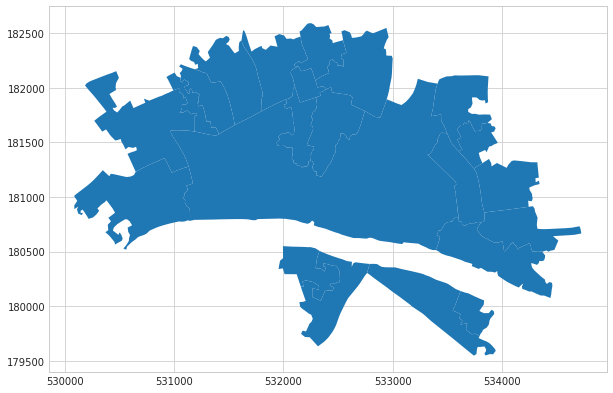

In [35]:
fig, ax = plt.subplots(figsize=(10,20))
print(len(map_df))
map_df.plot(ax=ax)


In [41]:
import folium
from folium.plugins import HeatMap
import branca.colormap as cm

colormap_colors = ['blue', 'yellow', 'red']
s_rng = [-1,1]
colormap = cm.LinearColormap(colormap_colors, vmin=s_rng[0], vmax=s_rng[1]).to_step(100)

#Add the Geopanda dataframe to a folium map
#mid_location = [map_df['Latitude'].mean(), map_df['Longitude'].mean()]
#folium_map = folium.Map(location=mid_location,
folium_map = folium.Map(
                        zoom_start=12)#, tiles="Mapbox")
folium.GeoJson(map_df).add_to(folium_map)
folium_map

In [ ]:
import json
with open('ga_corporations_address.json') as data_file:
    data = json.load(data_file)

def search_array(array,city):
    filtered_result = [];
    for inner_arr in array:
        inner_arr[4] = inner_arr[4].lower()
    for value in array:
        if city.lower() in value:
            value[4] = value[4].upper()
            filtered_result.append(value)
    return filtered_result

json_rows = data['table_rows']['rows']
filtered_array = search_array(json_rows,"LAWRENCEVILL")
data['table_rows']['count'] = len(filtered_array)
data['table_rows']['rows'] = filtered_array

if len(filtered_array) !=0:
    print(json.dumps(data))
else:
    print("No results found")


In [141]:
import folium
from folium.plugins import HeatMap
import branca.colormap as cm

colormap_colors = ['blue', 'yellow', 'red']
s_rng = [-1,1]
colormap = cm.LinearColormap(colormap_colors, vmin=s_rng[0], vmax=s_rng[1]).to_step(100)

geo_cols=["Local_Authority_District",
          "Local_Authority_Highway",
          "Latitude",
          "Longitude",
          "Location_Easting_OSGR",
          "Location_Northing_OSGR",
          "LSOA_of_Accident_Location"] 

def plot_map(df_view, col, criteria, field, max_samples=10000, min_opacity=0.1):
    df = spark.sql("SELECT latitude, longitude, {} FROM {} WHERE {} = {} ".format(field, df_view, col, "'"+criteria+"'"))\
    .toPandas().dropna().sample(max_samples)
    folium_map = folium.Map(location=[54.197496,-3.886918],
                        zoom_start=6, tiles="Mapbox Bright")
    max_amount = df[field].max()
    gradient = {0: colormap_colors[0], 0.5: colormap_colors[1], 1.0: colormap_colors[2]}
    heat_map = HeatMap( list(zip(df.latitude.values,df.longitude.values,df[field].values)),
                min_opacity=min_opacity, max_val=max_amount, radius=5, blur=5, 
                max_zoom=1, gradient=gradient)
    return folium_map.add_child(heat_map)